In [1]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import contextlib
import os
from importlib import reload

import torchvision
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
import torch

plt.rcParams['axes.facecolor'] = 'white'

In [2]:
import renyi
import utils
from renyi import mink_sim_divergence, renyi_mixture_divergence, mink_mixture_divergence, rbf_kernel, poly_kernel, generic_kernel, multiquad_kernel
from renyi import test_mixture_divergence

In [3]:
# torch.set_default_dtype(torch.float64)

class GeneratorFC(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims):
        super(GeneratorFC, self).__init__()
        self.layers = []

        prev_dim = input_size
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.LeakyReLU())
            prev_dim = hidden_dim
        self.layers.append(nn.Linear(prev_dim, output_size))

        self.layer_module = nn.ModuleList(self.layers)

    def forward(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out

In [18]:
from sklearn.datasets.samples_generator import make_swiss_roll

d, z_dim, gen_hiddens = 2, 16, [256, 256]
batch_size_p = 512
batch_size_q = 512

In [19]:
generator = GeneratorFC(z_dim, d, gen_hiddens).cuda()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [28]:
alpha = 1

# emp_probs = 2*torch.ones(1, batch_size//2).cuda()/batch_size
emp_probs_p = torch.ones(1, batch_size_p).cuda()/batch_size_p
emp_probs_q = torch.ones(1, batch_size_q).cuda()/batch_size_q

kernel = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[0.2]))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: multiquad_kernel(u, v, sigma=0.2))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: poly_kernel(u, v, degree=2))

# D = lambda x, y: renyi_mixture_divergence(emp_probs_p, x, emp_probs_q, y, kernel, alpha,
#                                           use_avg=False, use_full=True, symmetric=False)
D = lambda x, y: test_mixture_divergence(emp_probs_p, x, emp_probs_q, y, kernel, use_avg=True,
                                         symmetric=True)

for g in g_optimizer.param_groups:
    g['lr'] = 1e-5

for _ in range(5000):
    
    g_optimizer.zero_grad()
    
    x_real = torch.Tensor(make_swiss_roll(batch_size_p, noise=0.1)[0][:, [0, 2]]/10).cuda()
    x_real += 0.01 * torch.randn_like(x_real)
    
    z = torch.randn(batch_size_q, z_dim).cuda()
    with contextlib.nullcontext():  # autograd.detect_anomaly():
        x_fake = generator(z)

#         x = x_real[:batch_size//2]
#         x_prime = x_real[batch_size//2:]
#         y = x_fake[:batch_size//2]
#         y_prime = x_fake[batch_size//2:]

#         loss = D(x, y) + D(x_prime, y) + D(x, y_prime) + D(x_prime, y_prime) - 2*D(y, y_prime)
        loss = D(x_real, x_fake)

        if _ % 200 == 0:
            print("%d - %.4f" % (_, loss.item()))

        loss.backward()

    g_optimizer.step()

0 - 0.0149
200 - 0.0223
400 - 0.0177
600 - 0.0255
800 - 0.0236
1000 - 0.0228
1200 - 0.0230
1400 - 0.0171
1600 - 0.0157
1800 - 0.0178
2000 - 0.0218
2200 - 0.0144
2400 - 0.0142
2600 - 0.0176
2800 - 0.0191
3000 - 0.0180
3200 - 0.0148
3400 - 0.0126
3600 - 0.0221
3800 - 0.0200
4000 - 0.0207
4200 - 0.0175
4400 - 0.0180
4600 - 0.0139
4800 - 0.0176


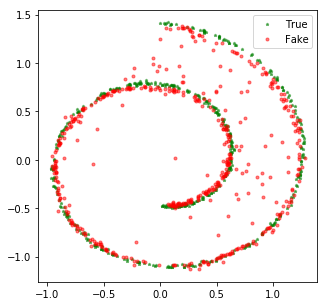

In [29]:
x_real = make_swiss_roll(500, noise=0.1)[0][:, [0, 2]]/10
z = torch.randn(500, z_dim).cuda()
x_fake = generator(z).data.cpu().numpy()

plt.figure(figsize=(5, 5))
plt.plot(x_real[:, 0], x_real[:, 1], 'g*', alpha=0.5, label='True', markersize=3)
plt.plot(x_fake[:, 0], x_fake[:, 1], 'ro', alpha=0.5, label='Fake', markersize=3)
plt.legend(loc='best');